# Label-free classification comparison between IDEAS and SCIP features

In this notebook, we will compare feature sets generated using IDEAS and SCIP. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# %load ../common_.py
import sys
sys.path.append("../..")
from common import *

In [78]:
import seaborn
import fcsparser
from sklearn.preprocessing import scale
from scipy.stats import pearsonr, spearmanr
from ehv import core

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier

from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from xgboost import XGBClassifier

In [4]:
from ehv import masking

# Data

In [ ]:
data_root = Path(os.environ["VSC_DATA_VO_USER"]) / "datasets/wbc"

In [6]:
data_root = Path("/home/maximl/scratch/data/vsc/datasets/wbc/")

In [7]:
data_scip = data_root / "scip/202204271347/"
data_ideas = data_root / "ideas/202111121025/"

In [11]:
df_scip = pq.read_table(data_scip / "features.parquet").to_pandas()

cat_type = CategoricalDtype(
    categories=sorted(df_scip["meta_group"].astype(int).unique()), ordered=True)
df_scip["meta_group"] = df_scip["meta_group"].astype(int).astype(cat_type)

cat_type = CategoricalDtype(
    categories=sorted(df_scip["meta_part"].astype(int).unique()), ordered=True)
df_scip["meta_part"] = df_scip["meta_part"].astype(int).astype(cat_type)

df_scip = df_scip.set_index(["meta_group", "meta_part", "meta_fix", "meta_object_number"])

df_scip = df_scip[numpy.load(
    data_scip / "indices/columns.npy", allow_pickle=True)]
df_scip = df_scip.loc[numpy.load(
    data_scip / "indices/index.npy", allow_pickle=True)]

df_scip["meta_label"] = pandas.Categorical(df_scip["meta_label"], ordered=True)

df_scip.shape

(233262, 2200)

In [12]:
# ideas features
def proc_cols(cols):
    out = []
    for col in cols:
        col = col.lower()
        for c in [" ", "-", "_", "."]:
            col = col.replace(c, "")
        out.append(col)
    return out

tmp = []
cols = None
for p in data_ideas.glob('*.fcs'):
    meta, data = fcsparser.parse(p)
    groups = re.search("wbc(?P<group>[0-9])_(?P<part>[0-9])_?(?P<fix>(early|late))?.fcs", p.name).groupdict()
    data["fix"] = groups["fix"]
    data["group"] = int(groups["group"])
    data["part"] = int(groups["part"])
    data.columns = proc_cols(data.columns)
    if cols is None:
        cols = data.columns  
    tmp.append(data[cols])
df_ideas = pandas.concat(tmp, axis=0)

r = r"(?i).*(uncompensated|bkgd|saturation|\().*" 
todrop = list(filter(lambda x: re.match(r, x), df_ideas.columns))
df_ideas = df_ideas.drop(columns=todrop)

ideas_meta_cols = ["objectnumber", "fix", "group", "part"]
df_ideas = df_ideas.rename(columns=lambda col: f"meta_{col.lower()}" if col in ideas_meta_cols else f"feat_{col.lower()}")

df_ideas["meta_object_number"] = df_ideas["meta_objectnumber"].astype(int)
df_ideas = df_ideas.drop(columns="meta_objectnumber")

df_ideas = df_ideas.set_index(["meta_object_number", "meta_part", "meta_group", "meta_fix"])

df_ideas.shape

(274050, 305)

In [16]:
df = df_scip.rename(columns=lambda a: "scip_"+a).join(
    df_ideas.rename(columns=lambda a: "ideas_"+a), 
    on=["meta_object_number", "meta_part", "meta_group", "meta_fix"], 
    how="left", lsuffix="ideas", rsuffix="scip"
)
df.shape

(233262, 2505)

In [23]:
def rename(c):
    if c.startswith("scip_meta"):
        return "meta_" + c[10:]
    return c
df = df.rename(columns=rename)

# Classification

In [79]:
def predict_gates(X, y, model, seed=42):
    numpy.random.seed(seed)
    
    scoring = ('balanced_accuracy', 'f1_macro', 'precision_macro', 'recall_macro')
    cv_results = cross_validate(
        estimator=model,
        X=X.values, y=y, cv=StratifiedKFold(n_splits=5, shuffle=True),
        scoring=scoring,
        return_train_score=True,
        return_estimator=True,
        n_jobs=5,
        verbose=0
    )
    cv_df = pandas.DataFrame(
        data = {
            **{"phase": ["train"] * 5 + ["test"] * 5},
            **{k: numpy.concatenate([cv_results[f"train_{k}"], cv_results[f"test_{k}"]]) for k in scoring}
        }
    ).melt(id_vars=["phase"])
    seaborn.stripplot(data=cv_df, y="variable", x="value", hue="phase", jitter=0)
    return cv_df, cv_results

In [80]:
enc = LabelEncoder().fit(df["meta_label"])
y = enc.transform(df["meta_label"])

CPU times: user 1.03 s, sys: 3.98 s, total: 5.01 s
Wall time: 13min 4s


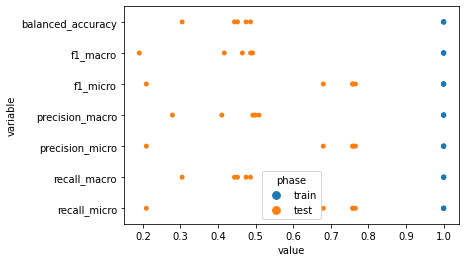

In [29]:
%%time
model = tree.DecisionTreeClassifier(class_weight="balanced")
_ = predict_gates(
    df.filter(regex="scip.*(BF1|BF2|SSC)$"), y, 
    model
)

CPU times: user 443 ms, sys: 2.4 s, total: 2.85 s
Wall time: 1min 41s


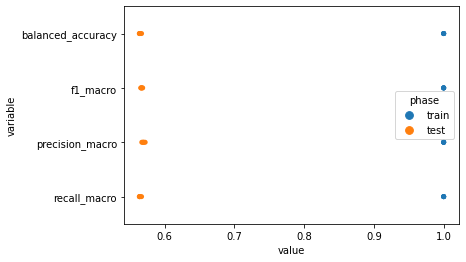

In [81]:
%%time
model = tree.DecisionTreeClassifier(class_weight="balanced")
_ = predict_gates(
    df.filter(regex="ideas.*(bf420nm480nm|bf570nm595nm|m01|m06|m09|ssc)$"), y, 
    model
)

CPU times: user 7.82 s, sys: 2.1 s, total: 9.92 s
Wall time: 8min 30s


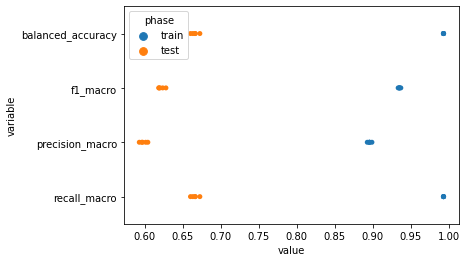

In [82]:
%%time
model_xgb = make_pipeline(
    RandomUnderSampler(sampling_strategy="majority", random_state=0),
    RandomOverSampler(sampling_strategy="not majority", random_state=0),
    XGBClassifier(
        booster="gbtree",  
        objective="multi:softmax", 
        eval_metric="merror",
        tree_method="gpu_hist",
        use_label_encoder=False,
        n_estimators=500
    )
)
_, results_scip = predict_gates(
    df.filter(regex="scip.*(BF1|BF2|SSC)$"), y, 
    model_xgb
)

CPU times: user 6.52 s, sys: 3.14 s, total: 9.65 s
Wall time: 4min 11s


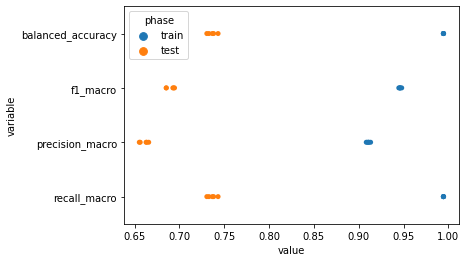

In [83]:
%%time
model_xgb = make_pipeline(
    RandomUnderSampler(sampling_strategy="majority", random_state=0),
    RandomOverSampler(sampling_strategy="not majority", random_state=0),
    XGBClassifier(
        booster="gbtree",  
        objective="multi:softmax", 
        eval_metric="merror",
        tree_method="gpu_hist",
        use_label_encoder=False,
        n_estimators=500
    )
)
_, results_ideas = predict_gates(
    df.filter(regex="ideas.*(bf420nm480nm|bf570nm595nm|m01|m06|m09|ssc)$"), y, 
    model_xgb
)

In [84]:
def fi(estimators):
    a = numpy.array([e.named_steps["xgbclassifier"].feature_importances_ for e in estimators])
    return a

fi_ideas = fi(results_ideas["estimator"])
fi_scip = fi(results_scip["estimator"])

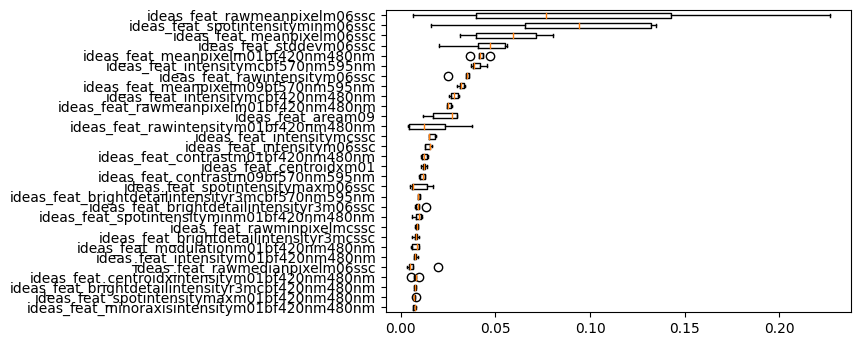

In [85]:
sorted_idx = fi_ideas.mean(axis=0).argsort()[-30:]

fig, ax = plt.subplots(1, dpi=100)
ax.boxplot(
    fi_ideas.T[sorted_idx].T,
    vert=False,
    labels=df.filter(regex="ideas.*(bf420nm480nm|bf570nm595nm|m01|m06|m09|ssc)$").columns[sorted_idx],
);

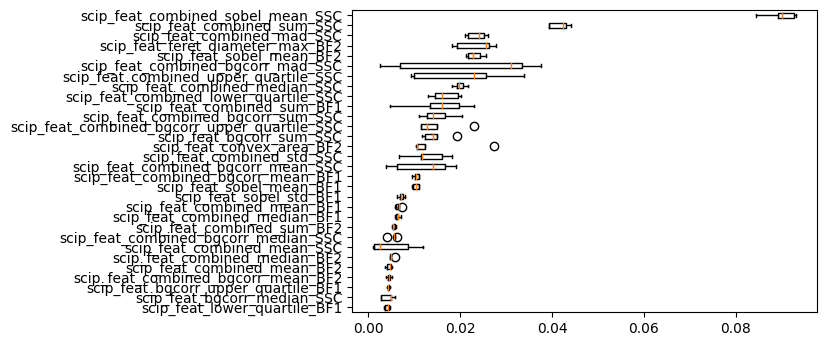

In [86]:
sorted_idx = fi_scip.mean(axis=0).argsort()[-30:]

fig, ax = plt.subplots(1, dpi=100)
ax.boxplot(
    fi_scip.T[sorted_idx].T,
    vert=False,
    labels=df.filter(regex="scip.*(BF1|BF2|SSC)$").columns[sorted_idx],
);